# Import

## Import Libraries

In [1]:
#pip install -r requirements.txt


In [2]:
import sys
import os

# Add the parent directory of 'src' to the path
sys.path.append(os.path.abspath('..'))

In [3]:
import random
from copy import deepcopy
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from itertools import product
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
import pickle
import seaborn as sns
from collections import Counter


from lib.Projectsolution import Solution
import importlib
import lib.genetic_algorithm
import lib.crossover
import lib.mutation
import lib.fitness
import lib.selection
import lib.Projectsolution

importlib.reload(lib.genetic_algorithm)
importlib.reload(lib.crossover)
importlib.reload(lib.mutation)
importlib.reload(lib.fitness)
importlib.reload(lib.selection)
importlib.reload(lib.Projectsolution)

from lib.genetic_algorithm import genetic_algorithm
from lib.crossover import pmx_crossover, order_crossover
from lib.mutation import swap_mutation, inversion_mutation, insertion_mutation, prime_slot_mutation, slot_shuffle_mutation
from lib.fitness import fitness
from lib.selection import tournament_selection, ranking_selection
from lib.Projectsolution import Solution



## Import Data

In [4]:
# Load artists data
artists_df = pd.read_csv("../data/artists(in).csv")

# Preview the first few rows
print(artists_df.head())

print(f"\n Number of artists: {len(artists_df)}")

   Unnamed: 0             name       genre  popularity
0           0    Midnight Echo        Rock          75
1           1      Solar Flare  Electronic          78
2           2     Velvet Pulse        Jazz          35
3           3     Neon Reverie  Electronic         100
4           4  The Silver Owls   Classical          85

 Number of artists: 35


In [5]:
# Load conflic matrix
conflict_df = pd.read_csv("../data/conflicts(in).csv", index_col=0)

# Convert to NumPy matrix for easier computation later
conflict_matrix = conflict_df.to_numpy()

# Check matrix size
print("Conflict matrix shape:", conflict_matrix.shape)

Conflict matrix shape: (35, 35)


# EDA & Minor changes

In [6]:
artists_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  35 non-null     int64 
 1   name        35 non-null     object
 2   genre       35 non-null     object
 3   popularity  35 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 1.2+ KB


In [7]:
# Rename the column
artists_df.rename(columns={"Unnamed: 0": "id"}, inplace=True)

# Confirm the change
print(artists_df.head())

   id             name       genre  popularity
0   0    Midnight Echo        Rock          75
1   1      Solar Flare  Electronic          78
2   2     Velvet Pulse        Jazz          35
3   3     Neon Reverie  Electronic         100
4   4  The Silver Owls   Classical          85


In [8]:
# Convert the 'genre' column in the DataFrame into numeric codes
# 'genre_code' will contain the numeric representation of each genre
# 'genre_uniques' will contain the list of unique genres in the order they were assigned
artists_df['genre_code'], genre_uniques = pd.factorize(artists_df['genre'])

# Display the first few rows of the original 'genre' column and the new 'genre_code' column
print(artists_df[['genre', 'genre_code']].head(20))

         genre  genre_code
0         Rock           0
1   Electronic           1
2         Jazz           2
3   Electronic           1
4    Classical           3
5   Electronic           1
6          Pop           4
7         Rock           0
8    Classical           3
9         Jazz           2
10        Jazz           2
11     Hip-Hop           5
12         Pop           4
13        Rock           0
14        Rock           0
15        Rock           0
16   Classical           3
17   Classical           3
18        Rock           0
19  Electronic           1


In [9]:
genre_uniques

Index(['Rock', 'Electronic', 'Jazz', 'Classical', 'Pop', 'Hip-Hop'], dtype='object')

In [10]:
# Normalize the 'popularity' column using MinMaxScaler
popularity = artists_df[['popularity']].values  
scaler = MinMaxScaler()
artists_df['popularity_norm'] = scaler.fit_transform(popularity)
print(artists_df['popularity_norm'].head())


0    0.6875
1    0.7250
2    0.1875
3    1.0000
4    0.8125
Name: popularity_norm, dtype: float64


In [11]:
# Define a class to represent each artist with relevant attributes
class Artist:
    def __init__(self, id, name, popularity, genre, genre_code, popularity_norm):
        # Initialize artist attributes with provided values
        self.id = id
        self.name = name
        self.popularity = popularity
        self.genre = genre
        self.genre_code = genre_code
        self.popularity_norm = popularity_norm

    def __repr__(self):
        # Define how the artist object will be displayed when printed
        return f"{self.name} (Pop: {self.popularity}, Genre: {self.genre}, NormPop: {self.popularity_norm})"


# Create a list of Artist objects by iterating over each row in the DataFrame
artists = [
    Artist(row["id"], row["name"], row["popularity"], row["genre"], row["genre_code"], row['popularity_norm'])
    for _, row in artists_df.iterrows()
]

In [12]:
artists

[Midnight Echo (Pop: 75, Genre: Rock, NormPop: 0.6875),
 Solar Flare (Pop: 78, Genre: Electronic, NormPop: 0.7250000000000001),
 Velvet Pulse (Pop: 35, Genre: Jazz, NormPop: 0.1875),
 Neon Reverie (Pop: 100, Genre: Electronic, NormPop: 1.0),
 The Silver Owls (Pop: 85, Genre: Classical, NormPop: 0.8125),
 Echo Chamber (Pop: 98, Genre: Electronic, NormPop: 0.9750000000000001),
 Aurora Skies (Pop: 75, Genre: Pop, NormPop: 0.6875),
 Static Mirage (Pop: 94, Genre: Rock, NormPop: 0.925),
 Crimson Harmony (Pop: 20, Genre: Classical, NormPop: 0.0),
 Deep Resonance (Pop: 90, Genre: Jazz, NormPop: 0.875),
 The Wandering Notes (Pop: 84, Genre: Jazz, NormPop: 0.8),
 Phantom Groove (Pop: 47, Genre: Hip-Hop, NormPop: 0.3375),
 Blue Horizon (Pop: 51, Genre: Pop, NormPop: 0.38750000000000007),
 Lunar Spectrum (Pop: 99, Genre: Rock, NormPop: 0.9875),
 Synthwave Saints (Pop: 94, Genre: Rock, NormPop: 0.925),
 Golden Ember (Pop: 61, Genre: Rock, NormPop: 0.5125000000000001),
 Mystic Rhythms (Pop: 78, Gen

In [13]:
conflict_matrix[:5, :5]  

array([[0. , 0. , 0. , 0.2, 0.5],
       [0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 1. , 0.5],
       [0.2, 1. , 1. , 0. , 0.2],
       [0.5, 0. , 0.5, 0.2, 0. ]])

In [14]:
artists_df.head()

,id,name,genre,popularity,genre_code,popularity_norm
0,0,Midnight Echo,Rock,75,0,0.6875
1,1,Solar Flare,Electronic,78,1,0.7250
2,2,Velvet Pulse,Jazz,35,2,0.1875
3,3,Neon Reverie,Electronic,100,1,1.0000
4,4,The Silver Owls,Classical,85,3,0.8125


# Tests 

In [15]:
# Create a list with all the values from the 'id' column of the DataFrame artists_df
artist_ids = list(artists_df['id'])

# Initialize an empty list to store the fitness values throughout the evolutionary process
fitness_history = []

In [16]:
# Define the methods for testing
crossover_methods = ['pmx', 'ox']
mutation_methods = ['insertion', 'prime','shuffle']
selection_methods = [tournament_selection, ranking_selection]
selection_methods = [
    (tournament_selection, {'k': 3}),
    (ranking_selection, {'pressure': 1.7}),
]

# Set crossover and mutation probabilities
xo_prob = 0.9
mut_prob = 0.1

# Initialize variables to track the best results
best_fitness = -float('inf')  # Start with a very low value
best_combination = None  # To store the best combination of parameters
best_solution = None  # To store the best solution

# Iterate through all combinations of parameters
for xo, mut, sel in product(crossover_methods, mutation_methods, selection_methods):
    print(f"Testing crossover: {xo}, mutation: {mut}, selection: {sel.__name__}")

    # Initialize the population for the current combination of parameters
    pop = [
        Solution(
            random.sample(artist_ids, len(artist_ids)),
            artists=artists,
            conflict_matrix=conflict_matrix,
            crossover_method=xo,
            mutation_method=mut
        )
        for _ in range(100) 
    ]

    # Run the genetic algorithm with the current population and parameters
    current_best_solution, fitness_over_time = genetic_algorithm(
        initial_population=pop,
        max_gen=100,
        selection_algorithm=sel,
        maximization=True,
        xo_prob=xo_prob,  
        mut_prob=mut_prob,  
        elitism=True,
        verbose=False,
        track_history=True # Track fitness per generation
    )

    # Get the fitness of the current best solution
    current_fitness = current_best_solution.fitness()

    print(f"Best fitness: {current_fitness:.4f}")

    # If the current fitness is better than the best fitness so far, update the best results
    if current_fitness > best_fitness:
        best_fitness = current_fitness
        best_combination = (xo, mut, sel)
        best_solution = current_best_solution

    # Plot fitness over time to check convergence behavior
    plt.plot(fitness_over_time)
    plt.title(f"Fitness over Generations ({xo}, {mut}, {sel.__name__})")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.grid(True)
    plt.show()

# After the loop, print the best combination and the best solution
print("\nBest combination of parameters:")
print(f"Crossover: {best_combination[0]}")
print(f"Mutation: {best_combination[1]}")
print(f"Selection: {best_combination[2].__name__}")

# Print the best solution
print("\nBest solution:")
# Print the fitness of the best solution
print(f"\nFitness: {best_solution.fitness():.4f}")

# Print the solution (the order of artists)
print(best_solution)


AttributeError: 'tuple' object has no attribute '__name__'

In [17]:
POP_SIZE=200 #50,100,200
GENERATIONS=200 #50,100,200
param_options = {
    "xo_prob": [random.uniform(0, 1/3), random.uniform(1/3, 2/3), random.uniform(2/3, 1)],
    "mut_prob": [random.uniform(0, 1/3), random.uniform(1/3, 2/3), random.uniform(2/3, 1)],
    "crossover_methods": ['pmx', 'ox'],
    "mutation_methods": ['insertion', 'prime', 'shuffle'],
    "selection_methods": [
        (tournament_selection, {'k': 3}),
        (ranking_selection, {'pressure': 1.7})
    ]
}


In [18]:
def sample_random_configs(param_dict, n_samples):
    # Get all options as lists
    keys = list(param_dict.keys())
    all_combinations = list(product(*param_dict.values()))
    
    if n_samples > len(all_combinations):
        print(f"Warning: Requested {n_samples} samples but only {len(all_combinations)} unique combos available.")
        n_samples = len(all_combinations)
        
    sampled_combinations = random.sample(all_combinations, n_samples)
    
    return [
        dict(zip(keys, combo))
        for combo in sampled_combinations
    ]

In [19]:
runs_per_config = 10
num_samples = 20  

sampled_configs = sample_random_configs(param_options, num_samples)

finetune_fitness_results = []

artist_ids = list(artists_df['id'])

for config in sampled_configs:
    config_results = []

    for run_nr in range(runs_per_config):
        initial_population = [
            Solution(
                random.sample(artist_ids, len(artist_ids)),
                artists=artists,
                conflict_matrix=conflict_matrix,
                crossover_method=config['crossover_methods'],
                mutation_method=config['mutation_methods']
            )
            for _ in range(POP_SIZE)
        ]

        best_solution, _ = genetic_algorithm(
            initial_population=initial_population,
            max_gen=GENERATIONS,
            selection_algorithm=config['selection_methods'][0],
            maximization=True,
            xo_prob=config['xo_prob'],
            mut_prob=config['mut_prob'],
            elitism=True,
            verbose=False,
            track_history=False,
            **config['selection_methods'][1]
        )

        config_results.append(best_solution.fitness())

    config_label = (
        f"xo_prob={round(config['xo_prob'], 2)}_mut_prob={round(config['mut_prob'], 2)}_"
        f"xo={config['crossover_methods']}_mut={config['mutation_methods']}_"
        f"sel={config['selection_methods'][0].__name__}"
    )

    finetune_fitness_results.append({
        'Configuration': config_label,
        'Fitness_Values': config_results
    })


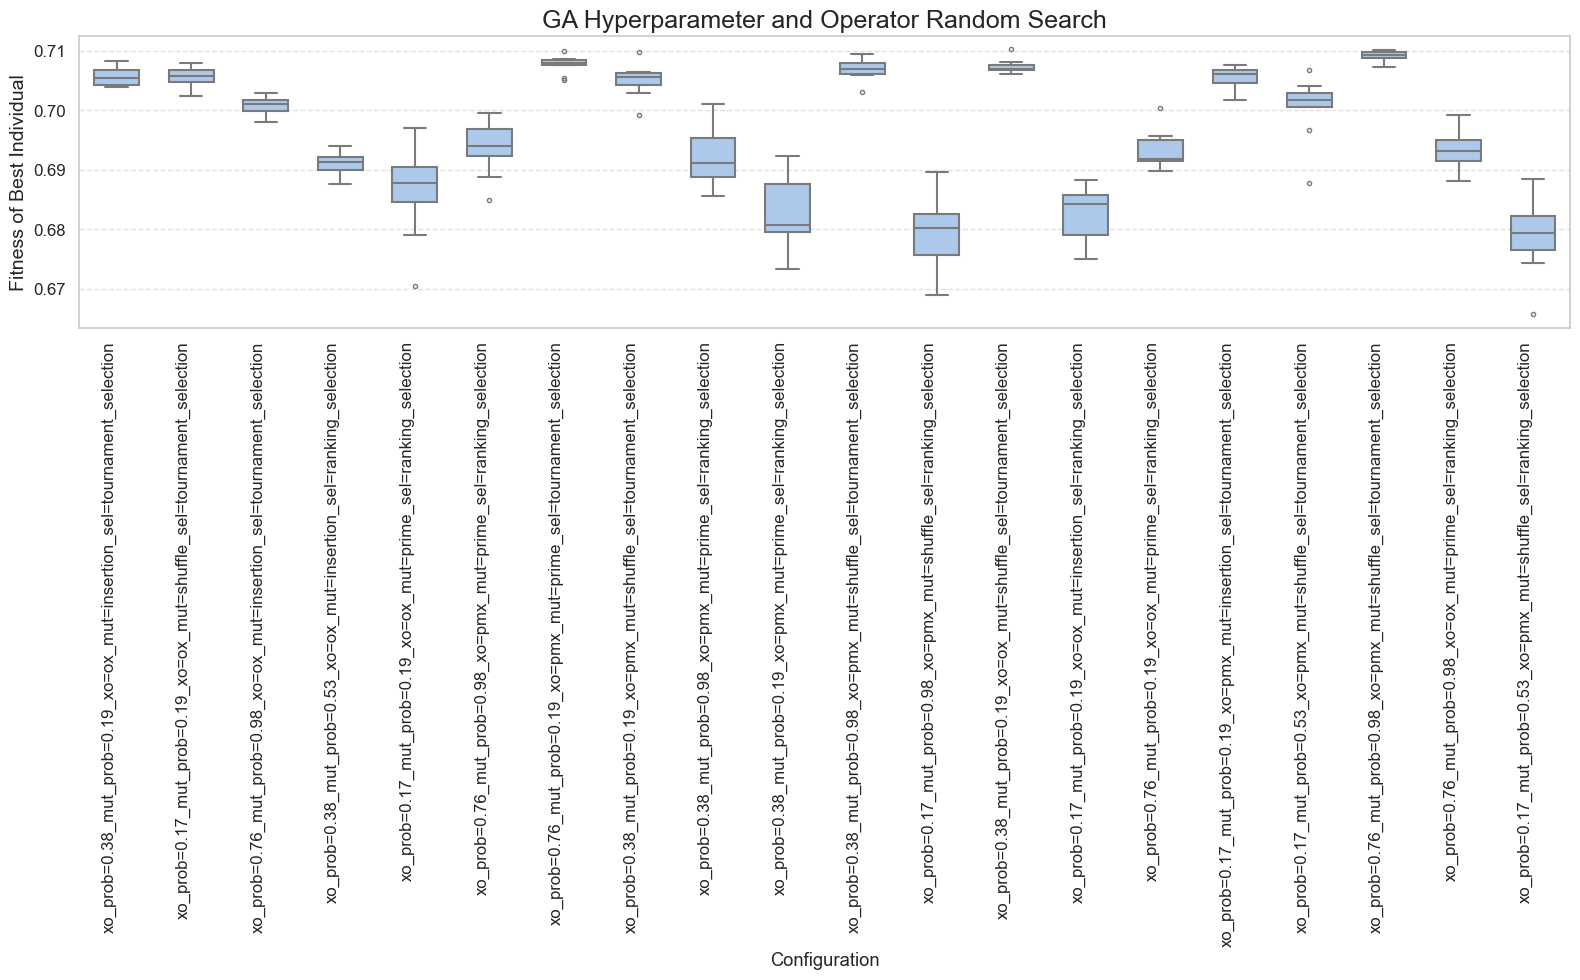

In [20]:
data = []
for entry in finetune_fitness_results:
    for value in entry['Fitness_Values']:
        data.append({
            'Fitness': value,
            'Configuration': entry['Configuration']
        })

df_long = pd.DataFrame(data)

sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.1)
plt.figure(figsize=(16, 10))
ax = sns.boxplot(x='Configuration', y='Fitness', data=df_long, width=0.6, linewidth=1.5, fliersize=3)

plt.title('GA Hyperparameter and Operator Random Search', fontsize=18)
plt.ylabel('Fitness of Best Individual', fontsize=14)
plt.xticks(rotation=90, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [21]:
# Convert long-format data to a DataFrame
df_long = pd.DataFrame([
    {'Configuration': entry['Configuration'], 'Fitness': value}
    for entry in finetune_fitness_results
    for value in entry['Fitness_Values']
])

# Export to CSV
df_long.to_csv("ga_fitness_results.csv", index=False)
print("Fitness results exported to 'ga_fitness_results.csv'")

Fitness results exported to 'ga_fitness_results.csv'


In [22]:
# Get best configuration by average fitness
best_result = max(
    finetune_fitness_results,
    key=lambda x: sum(x['Fitness_Values']) / len(x['Fitness_Values'])
)

# Stats
avg_fitness = sum(best_result['Fitness_Values']) / len(best_result['Fitness_Values'])
max_fitness = max(best_result['Fitness_Values'])
min_fitness = min(best_result['Fitness_Values'])

print("\nBest Configuration Found:")
print(f"Configuration: {best_result['Configuration']}")
print(f"Average Fitness: {avg_fitness:.2f}")
print(f"Max Fitness: {max_fitness:.2f}")
print(f"Min Fitness: {min_fitness:.2f}")



Best Configuration Found:
Configuration: xo_prob=0.76_mut_prob=0.98_xo=pmx_mut=shuffle_sel=tournament_selection
Average Fitness: 0.71
Max Fitness: 0.71
Min Fitness: 0.71


In [23]:
# Count frequency of crossover, mutation, and selection methods
xo_counter = Counter()
mut_counter = Counter()
sel_counter = Counter()

for entry in finetune_fitness_results:
    config = entry['Configuration']
    # Extract substrings
    if 'xo=' in config and 'mut=' in config and 'sel=' in config:
        xo_method = config.split('xo=')[1].split('_')[0]
        mut_method = config.split('mut=')[1].split('_')[0]
        sel_method = config.split('sel=')[1]

        xo_counter[xo_method] += 1
        mut_counter[mut_method] += 1
        sel_counter[sel_method] += 1

print("\nMost Common Operators Among Sampled Configurations:")
print("Crossover Methods:", xo_counter)
print("Mutation Methods:", mut_counter)
print("Selection Methods:", sel_counter)



Most Common Operators Among Sampled Configurations:
Crossover Methods: Counter({'pmx': 11, 'ox': 9})
Mutation Methods: Counter({'shuffle': 8, 'prime': 7, 'insertion': 5})
Selection Methods: Counter({'tournament_selection': 10, 'ranking_selection': 10})


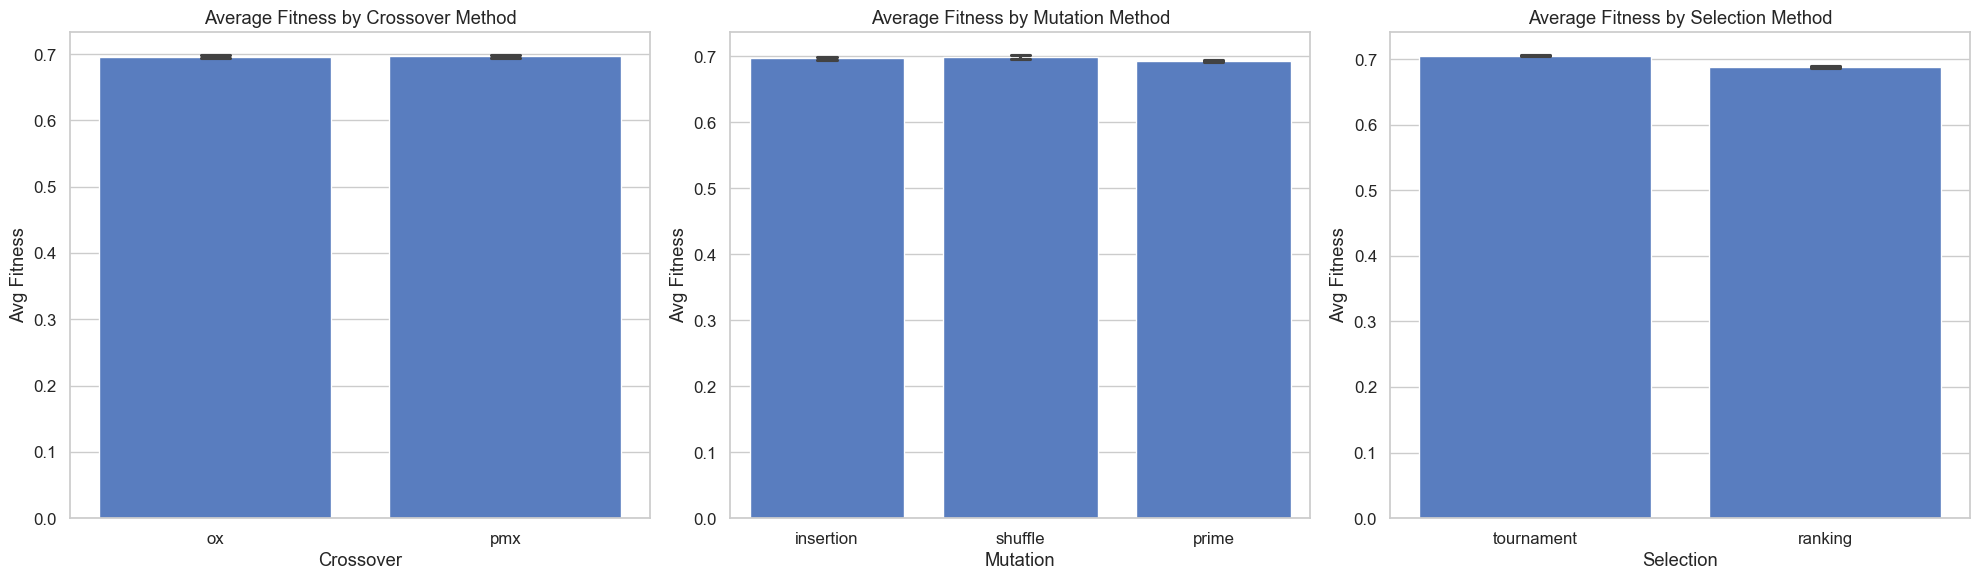

In [24]:
# Function to extract a field from configuration string
def extract_field(config_str, key):
    parts = config_str.split("_")
    for part in parts:
        if part.startswith(key + "="):
            return part.split("=")[1]
    return None

# Extract operators and pair with fitness
operator_data = []
for entry in finetune_fitness_results:
    for fitness in entry['Fitness_Values']:
        operator_data.append({
            'Fitness': fitness,
            'Crossover': extract_field(entry['Configuration'], 'xo'),
            'Mutation': extract_field(entry['Configuration'], 'mut'),
            'Selection': extract_field(entry['Configuration'], 'sel'),
        })

df_ops = pd.DataFrame(operator_data)

# Set up the theme
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)

# Create subplots for each operator type
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Crossover
sns.barplot(data=df_ops, x="Crossover", y="Fitness", ax=axes[0], errorbar="ci", capsize=0.1)
axes[0].set_title("Average Fitness by Crossover Method")
axes[0].set_ylabel("Avg Fitness")
axes[0].set_xlabel("Crossover")

# Mutation
sns.barplot(data=df_ops, x="Mutation", y="Fitness", ax=axes[1], errorbar="ci", capsize=0.1)
axes[1].set_title("Average Fitness by Mutation Method")
axes[1].set_ylabel("Avg Fitness")
axes[1].set_xlabel("Mutation")

# Selection
sns.barplot(data=df_ops, x="Selection", y="Fitness", ax=axes[2], errorbar="ci", capsize=0.1)
axes[2].set_title("Average Fitness by Selection Method")
axes[2].set_ylabel("Avg Fitness")
axes[2].set_xlabel("Selection")

plt.tight_layout()
plt.show()


In [25]:
# Number of stages and slots
num_stages = 5
num_slots = 7

# Get the best solution (list of indices)
best_artist_solution = [artists[i] for i in best_solution.representation]

# Create a 2D list (5 stages x 7 slots) to represent the schedule
schedule = [[None for _ in range(num_slots)] for _ in range(num_stages)]

# Fill the schedule with the artists based on the best solution
for stage in range(num_stages):
    for slot in range(num_slots):
        index = stage * num_slots + slot
        schedule[stage][slot] = best_artist_solution[index]

# Display the schedule
for stage in range(num_stages):
    print(f"Stage {stage + 1}:")
    for slot in range(num_slots):
        artist = schedule[stage][slot]
        print(f"  Slot {slot + 1}: {artist.name}, Popularity: {artist.popularity}, Genre: {artist.genre}")
    print()


Stage 1:
  Slot 1: Nightfall Sonata, Popularity: 84, Genre: Classical
  Slot 2: Neon Reverie, Popularity: 100, Genre: Electronic
  Slot 3: Synthwave Saints, Popularity: 94, Genre: Rock
  Slot 4: Phantom Groove, Popularity: 47, Genre: Hip-Hop
  Slot 5: Cosmic Frequency, Popularity: 53, Genre: Rock
  Slot 6: Blue Horizon, Popularity: 51, Genre: Pop
  Slot 7: Rhythm Alchemy, Popularity: 94, Genre: Jazz

Stage 2:
  Slot 1: The Bassline Architects, Popularity: 61, Genre: Hip-Hop
  Slot 2: The Polyrhythm Syndicate, Popularity: 66, Genre: Jazz
  Slot 3: Hypnotic Echoes, Popularity: 77, Genre: Rock
  Slot 4: Quantum Beat, Popularity: 96, Genre: Hip-Hop
  Slot 5: Crimson Harmony, Popularity: 20, Genre: Classical
  Slot 6: The Silver Owls, Popularity: 85, Genre: Classical
  Slot 7: Harmonic Dissonance, Popularity: 96, Genre: Classical

Stage 3:
  Slot 1: Midnight Echo, Popularity: 75, Genre: Rock
  Slot 2: Lunar Spectrum, Popularity: 99, Genre: Rock
  Slot 3: Aurora Skies, Popularity: 75, Genre:

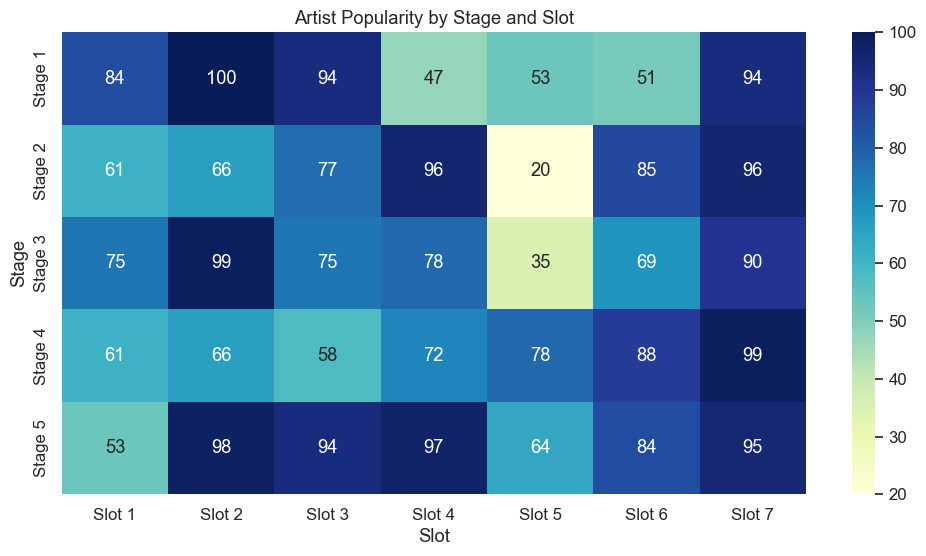

In [26]:
# Heatmap of popularity
popularity_matrix = [[schedule[stage][slot].popularity for slot in range(num_slots)] for stage in range(num_stages)]

plt.figure(figsize=(12, 6))
sns.heatmap(popularity_matrix, annot=True, fmt=".0f", cmap="YlGnBu", 
            xticklabels=[f"Slot {j+1}" for j in range(num_slots)],
            yticklabels=[f"Stage {i+1}" for i in range(num_stages)])
plt.title("Artist Popularity by Stage and Slot")
plt.xlabel("Slot")
plt.ylabel("Stage")
plt.show()